In [39]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Reference for customizing plots : http://matplotlib.org/users/customizing.html
# print(plt.style.available)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [40]:
### Loading the dataset provided
df_train = pd.read_json('/home/ubuntu/pramit/random/data/rental_listing/train.json')
df_test = pd.read_json('/home/ubuntu/pramit/random/data/rental_listing/test.json')

In [41]:
df_train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low


In [42]:
df_train["no_photos"] = df_train["photos"].apply(len)
df_train["no_features"] = df_train["features"].apply(len)
df_train["created_transformed"] = pd.to_datetime(df_train["created"])
df_train["created_yr"] = df_train["created_transformed"].dt.year
df_train["created_day"] = df_train["created_transformed"].dt.day
df_train["created_month"] = df_train["created_transformed"].dt.month
df_train['created_month_YrMnth'] = 100*df_train["created_yr"] + df_train["created_month"]

In [43]:
df_train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,price,street_address,interest_level,no_photos,no_features,created_transformed,created_yr,created_day,created_month,created_month_YrMnth
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,3000,792 Metropolitan Avenue,medium,5,0,2016-06-24 07:54:24,2016,24,6,201606
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,...,5465,808 Columbus Avenue,low,11,5,2016-06-12 12:19:27,2016,12,6,201606
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,...,2850,241 W 13 Street,high,8,4,2016-04-17 03:26:41,2016,17,4,201604
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,...,3275,333 East 49th Street,low,3,2,2016-04-18 02:22:02,2016,18,4,201604
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,...,3350,500 West 143rd Street,low,3,1,2016-04-28 01:32:41,2016,28,4,201604


In [44]:
df_train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'price', 'street_address', 'interest_level', 'no_photos', 'no_features', 'created_transformed', 'created_yr', 'created_day', 'created_month', 'created_month_YrMnth'], dtype='object')

In [57]:
np.unique(df_train['interest_level'])

array(['high', 'low', 'medium'], dtype=object)

In [45]:
# Starting with numerical features first
features_considered = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 
                       'no_photos', 'no_features', 'created_yr', 'created_day', 'created_month', 
                       'created_month_YrMnth']

In [51]:
X = df_train[features_considered]
# Converting 'str' class labels to numeric labels
y = df_train['interest_level'].astype('category').cat.codes
print("Converted Labels: {}".format(np.unique(y)))

Converted Labels: [0 1 2]


In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.30, random_state=42)

In [85]:
import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=8, n_estimators=500, learning_rate=0.1, n_jobs=-1).fit(X_train, y_train)

In [86]:
y_hat_train = gbm.predict(X_train)
y_hat_val = gbm.predict(X_val)

## Evaluation

In [87]:
from sklearn.metrics import classification_report

print("\n--------Train dataset classification report----------\n")
target_names = ['high', 'low', 'medium']
print(classification_report(y_train, y_hat_train, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
print(classification_report(y_val, y_hat_val, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

       high       0.98      0.85      0.91      2687
        low       0.92      0.99      0.95     23999
     medium       0.93      0.76      0.84      7860

avg / total       0.93      0.92      0.92     34546


--------Test dataset classification report----------

             precision    recall  f1-score   support

       high       0.49      0.26      0.34      1152
        low       0.79      0.90      0.84     10285
     medium       0.45      0.33      0.38      3369

avg / total       0.69      0.72      0.70     14806



## Using Skater to understand behavior

In [96]:
from skater.core.explanations import Interpretation
#from skater.core.global_interpretation.tree_surrogate import TreeSurrogate
from skater.util.dataops import show_in_notebook

interpreter = Interpretation(X_train, feature_names=features_considered)
# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(estimator_type='classifier', class_weight="balanced",
                                                 feature_names=features_considered, 
                                                 class_names=['0', '1', '2'], seed=42)

In [97]:
surrogate_explainer.learn(X_train, y_hat_train, oracle_y=y_train, preprune=False)

2018-08-23 19:29:17,797 - skater.model.base - WARNING - No examples provided, cannot infer model type
2018-08-23 19:29:17,809 - skater.core.global_interpretation.tree_surrogate - WARNING - fidelity score:0.0782287041937545 of the surrogate model is higher than the impurity threshold: 0.01


0.0782287041937545

In [98]:
y_hat = surrogate_explainer.predict(X_val)
print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_val, y_hat_val, target_names=target_names))


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.49      0.26      0.34      1152
    class 1       0.79      0.90      0.84     10285

avg / total       0.69      0.72      0.70     14806



In [99]:
%matplotlib inline
surrogate_explainer.plot_global_decisions(colors=['lightsteelblue', 'darkkhaki', 'aquamarine'], 
                                          file_name='surrogate_tree_rental_no_prune.png', show_img=False)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.065503 to fit



2018-08-23 19:38:16,569 - skater.util.dataops - INFO - File Name: surrogate_tree_rental_no_prune.png


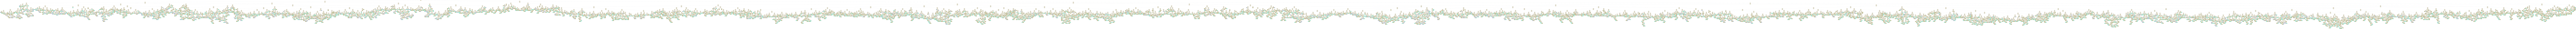

In [101]:
show_in_notebook('surrogate_tree_rental_no_prune.png', width=800, height=400)